In [1]:
import rasterio
import glob
import os
from rasterio.plot import show
from zipfile import ZipFile
import pandas as pd
import shutil
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
shutil.rmtree(f"./data/inputs/", ignore_errors=True)
shutil.rmtree(f"./data/outputs/", ignore_errors=True)

In [3]:
# Reading the data saved from running `sentinel_aois_data` notebook into dataframes.
DATA_DIR = "./data/files_list"
s1_au_df = pd.read_csv(os.path.join(DATA_DIR, "s1_au.csv"), names=["ID","Path"])
s1_an_df = pd.read_csv(os.path.join(DATA_DIR, "s1_an.csv"), names=["ID","Path"])
s2_au_df = pd.read_csv(os.path.join(DATA_DIR, "s2_au.csv"), names=["ID","Path"])
s2_an_df = pd.read_csv(os.path.join(DATA_DIR, "s2_an.csv"), names=["ID","Path"])

In [4]:
# These are other potential bands existing in the data.
S2_OTHER_BANDS_SUFFIX_LIST = ["AOT", "TCI", "WVP", "SCL"] 

In [5]:
def find_band_files_s2(dir:str, selected_res_index:int = -1) -> list[str]:
    """
    Retrieving band files from the data path `dir`, If there are multiple resolutions of the data, `selected_res_index` must be specified as a positive integer.
    """
    if selected_res_index == -1:
        band_files = [file for file in glob.glob(os.path.join(dir, "GRANULE", "*", "IMG_DATA", "*"))]
    else:
        band_dirs = [file for file in glob.glob(os.path.join(dir, "GRANULE", "*", "IMG_DATA", "*"))]
        selected_res = band_dirs[selected_res_index]
        band_files = glob.glob(f"{selected_res}/*")
    return band_files

In [6]:
def load_s2_bands(
        zip_file_path:str, 
        zip_file_id:str, 
        s2_other_bands_list:list[str], 
        subdir_name:str = "", 
        remove_input:bool = True,
        selected_res_index:int = -1,
    ) -> tuple:
    """
    Loads bands from the data.
    * `zip_file_path` and `zip_file_ids` are the path and id of the data.
    * The function also loads the other bands specified in the  other bands list
    * `subdir_name` will be added to the output directory path if provided
    * If there are multiple resolutions of the data, `selected_res_index` must be specified as a positive integer
    """
    with ZipFile(zip_file_path) as f:
        f.extractall(f"./data/inputs/{zip_file_id}/{subdir_name}")
    data_dir = os.listdir(f"./data/inputs/{zip_file_id}/{subdir_name}")[0]
    dir = os.path.join(f"./data/inputs/{zip_file_id}/{subdir_name}", data_dir)
    band_files = find_band_files_s2(dir, selected_res_index)
    other_band_files = []
    for suffix in s2_other_bands_list:
        other_band = list(filter(lambda b: suffix in b, band_files))
        if other_band != []:
            other_band_files.append(other_band[0])

    band_files = [bf for bf in band_files if bf not in other_band_files]
    bands = [rasterio.open(band_file) for band_file in band_files]

    other_bands = []
    for bf in other_band_files:
        other_bands.append(rasterio.open(bf))
    
    if remove_input:
        shutil.rmtree(f"./data/inputs/{zip_file_id}/{subdir_name}", ignore_errors=True)
    
    return bands, other_band

In [7]:
def dwonsample_dataset(dataset_path:str, scale_factor:float):
    """
    Downsamples the output data and returns the new downsampled data and its new affine transformation according to `scale_factor`
    """
    with rasterio.open(dataset_path) as dataset:
        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * scale_factor),
                int(dataset.width * scale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
    return data, transform

In [8]:
def write_true_color_s2(
        zip_id:str, 
        true_bands, 
        band_profile, 
        scale_factor = 0.03, 
        subdir_name = "",
    ) -> tuple:
    """
    writes a true color image using true color bands (not TCI). The updated profile for true bands shold be provided.
    also downsamples the output data and returns the new downsampled data and its new affine transformation according to `scale_factor`
    """
    output_dir = f"./data/outputs/{zip_id}/{subdir_name}/"
    if os.path.isdir(output_dir):
        shutil.rmtree(output_dir, ignore_errors=True)
    os.makedirs(output_dir, exist_ok=True)

    with rasterio.open(f"{output_dir}/out.tif", 'w', **band_profile) as dest_file:
        for i, b in enumerate(true_bands):
            dest_file.write(b.read(1), i + 1)
            
    new_data, new_transform = dwonsample_dataset(f"{output_dir}/out.tif", scale_factor)

    return new_data, new_transform

def enhance_color(data, uint16:bool=False):
    """
    Increases the brightness of the output data
    """
    if uint16:
        data = data / 256
    data = data.astype("float64")
    data *= 255 / data.max()
    return data.astype("uint8")


def extract_true_bands(bands):
    "Extracts true color bands and retuns them together with an updated profile for the bands"
    true_bands = [b for b in bands if os.path.basename(b.name).split("_")[2].replace(".jp2", "").strip() in ["B02", "B03", "B04"]]
    sortperm = np.argsort([b.name for b in true_bands])
    true_bands = [true_bands[i] for i in sortperm]
    band_profile = true_bands[0].profile
    band_profile.update({"count": len(true_bands)})
    return true_bands, band_profile


def plot_scene(data, data_transform):
    """
    Plots the true color image and blue band of the scene given the names of the scenes and their affine transformation
    """
    _, (axt, axb) = plt.subplots(1,2, figsize=(10, 20))
    show(enhance_color(data[1]), ax=axb, title="Single color band (B)", cmap="Blues", transform=data_transform)
    show(enhance_color(data), ax=axt, title="True colour bands image", transform=data_transform)

##### Sentinel 2 Australia

In [9]:
num_file = 100
zip_id = s2_au_df.ID[num_file]
zip_file = s2_au_df.Path[num_file]
subdir_name = f"sub{num_file}"
bands, _ = load_s2_bands(
    zip_file, 
    zip_id, 
    S2_OTHER_BANDS_SUFFIX_LIST, 
    subdir_name=subdir_name, 
    selected_res_index=0,
    remove_input=False,
)
true_bands, band_profile = extract_true_bands(bands)


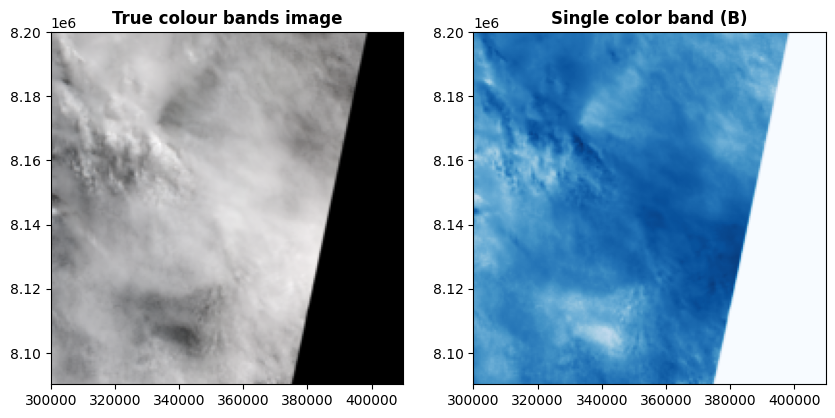

In [10]:
# true color
new_data, new_transform = write_true_color_s2(
    zip_id, 
    true_bands, 
    band_profile, 
    subdir_name=subdir_name,
    scale_factor=0.1
)
plot_scene(new_data, new_transform)

##### Sentinel 2 Antarctica

In [11]:
num_file = 70
zip_id = s2_an_df.ID[num_file]
zip_file = s2_an_df.Path[num_file]
subdir_name = f"sub{num_file}"
bands, _ = load_s2_bands(
    zip_file, 
    zip_id, 
    S2_OTHER_BANDS_SUFFIX_LIST, 
    subdir_name=subdir_name, 
    selected_res_index=0,
    remove_input=False,
)
true_bands, band_profile = extract_true_bands(bands)


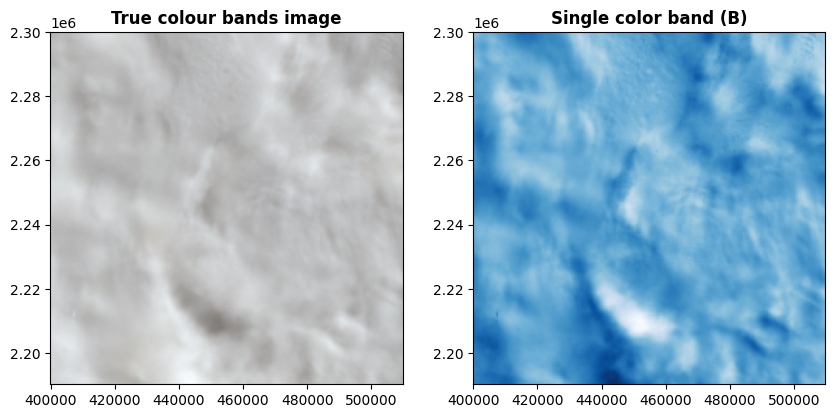

In [12]:
# true color
new_data, new_transform = write_true_color_s2(
    zip_id, 
    true_bands, 
    band_profile, 
    subdir_name=subdir_name,
    scale_factor=0.1
)
plot_scene(new_data, new_transform)